In [5]:
# === My new cell ===
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

# 1. Paths
data_dir  = Path(r"C:\Users\Raghav Singla\Desktop\PBL-4")
train_fp  = data_dir / "UNSW_NB15_training-set.csv"
test_fp   = data_dir / "UNSW_NB15_testing-set.csv"

# 2. Load
df_train = pd.read_csv(train_fp)
df_test  = pd.read_csv(test_fp)

# 3. Separate features/target, drop unneeded cols
drop_cols = ["id", "attack_cat"]
X_train   = df_train.drop(columns=drop_cols + ["label"])
y_train   = df_train["label"]
X_test    = df_test.drop(columns=drop_cols + ["label"])
y_test    = df_test["label"]

# 4. Encode categoricals
cat_cols = ["proto", "service", "state"]
for col in cat_cols:
    le = LabelEncoder()
    # fit on train + test to avoid unseen labels
    combined = pd.concat([X_train[col], X_test[col]]).astype(str)
    le.fit(combined)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col]  = le.transform(X_test[col].astype(str))

# 5. Ensure all others numeric, fill NaN with train‐set medians
X_train = X_train.apply(pd.to_numeric, errors="coerce")
X_test  = X_test.apply(pd.to_numeric,  errors="coerce")
medians = X_train.median()
X_train.fillna(medians, inplace=True)
X_test.fillna(medians,  inplace=True)

# 6. Quick sanity checks
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train label dist:\n", y_train.value_counts(normalize=True).round(3))
print("Test  label dist:\n", y_test.value_counts(normalize=True).round(3))


Train shape: (175341, 42)  Test shape: (82332, 42)
Train label dist:
 label
1    0.681
0    0.319
Name: proportion, dtype: float64
Test  label dist:
 label
1    0.551
0    0.449
Name: proportion, dtype: float64


In [6]:
# === My new cell ===
from sklearn.ensemble import RandomForestClassifier

# Instantiate and train
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

print("✅ RandomForest trained on", X_train.shape[0], "samples.")


✅ RandomForest trained on 175341 samples.


              precision    recall  f1-score   support

           0     0.9803    0.7325    0.8385     37000
           1     0.8190    0.9880    0.8956     45332

    accuracy                         0.8732     82332
   macro avg     0.8997    0.8602    0.8670     82332
weighted avg     0.8915    0.8732    0.8699     82332



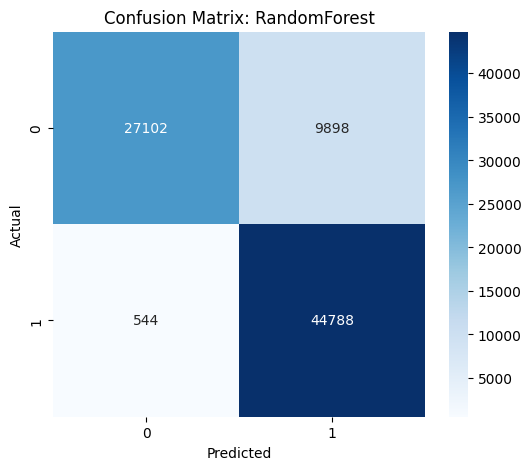

✔ Model persisted to ids_model.joblib


In [7]:
# === My new cell ===
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Inference
y_pred = rf.predict(X_test)

# 1. Detailed metrics
print(classification_report(y_test, y_pred, digits=4))

# 2. Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: RandomForest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. Save model
joblib.dump(rf, "ids_model.joblib")
print("✔ Model persisted to ids_model.joblib")


In [ ]:
# === My new cell ===
# 4. Compare RF vs KNN vs SVM vs LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

models = {
    "RandomForest": rf,  # your already‐trained RF
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "SVM": SVC(kernel="rbf", C=1.0, probability=True, random_state=42),
    "LogisticRegression": LogisticRegression(
        max_iter=1000, class_weight="balanced", random_state=42
    ),
}

for name, model in models.items():
    # retrain non-RF models
    if name != "RandomForest":
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))



=== RandomForest ===
              precision    recall  f1-score   support

           0     0.9803    0.7325    0.8385     37000
           1     0.8190    0.9880    0.8956     45332

    accuracy                         0.8732     82332
   macro avg     0.8997    0.8602    0.8670     82332
weighted avg     0.8915    0.8732    0.8699     82332


=== KNN ===
              precision    recall  f1-score   support

           0     0.8946    0.5981    0.7169     37000
           1     0.7418    0.9425    0.8302     45332

    accuracy                         0.7877     82332
   macro avg     0.8182    0.7703    0.7736     82332
weighted avg     0.8105    0.7877    0.7793     82332



In [ ]:
# === My new cell ===
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["accuracy", "f1", "roc_auc"]

for name, model in models.items():
    scores = {metric: cross_val_score(model, X_train, y_train, cv=cv,
                                      scoring=metric, n_jobs=-1)
              for metric in scoring}
    print(f"\n=== {name} CV Results ===")
    for metric, vals in scores.items():
        print(f"{metric:>9}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")


In [ ]:
# === My new cell ===
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for name, model in models.items():
    # ensure probability predictions
    y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.show()


In [ ]:
# === My new cell ===
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# get importances
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns)
top15 = feat_imp.sort_values(ascending=False).head(15)

plt.figure(figsize=(6,8))
sns.barplot(x=top15.values, y=top15.index)
plt.title("Top 15 Feature Importances (RandomForest)")
plt.xlabel("Importance"); plt.tight_layout()
plt.show()


In [ ]:
# === My new cell ===
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 10, 20, 50],
    "min_samples_split": [2, 5, 10]
}
rs = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    random_state=42
)
rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
print("Best CV F1:", rs.best_score_.round(4))

# Re-evaluate on test set
best_rf = rs.best_estimator_
y_pred_best = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_best, digits=4))


In [ ]:
# === My new cell ===
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(X_test)

plt.figure(figsize=(7,6))
plt.scatter(Xp[y_test==0,0], Xp[y_test==0,1], alpha=0.3, label="Normal")
plt.scatter(Xp[y_test==1,0], Xp[y_test==1,1], alpha=0.3, label="Attack")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA of Test Set Features")
plt.legend(); plt.tight_layout()
plt.show()
